# SVM tuning
Goal: tune a Support Vector Classifier.
<br>Learn more about the algorithm [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).
***

## Table of Contents 
1. [Intuition Behind Tuning Approach](#1.-Intuition-Behind-Tuning-Approach)
2. [Intuition Behind Evaluation Metrics](#2.-Intuition-Behind-Evaluation-Metrics)
3. [Load Data](#3.-Load-Data)
4. [Define Functions](#4.-Define-Functions)
5. [Building a Baseline Model](#5.-Building-a-Baseline-Model)
6. [Normalize Numerical Features](#6.-Normalize-Numerical-Features)
7. [Feature Correlation](#7.-Feature-Correlation)
<br>7.1 [Removing TotalCharges](#7.1-Removing-TotalCharges)
8. [Parameter C](#8.-Parameter-C)
9. [Final Model](#9.-Final-Model)

## 1. Intuition Behind Tuning Approach
1. **Build a baseline model** to measure efficacy of parameter tuning for evaluation metric improvements.
2. **Normalize numerical features** since SVMs are not scale invariant.
3. **Re-evaluate input features** to reduce some bias, redundancy, and dimensionality.
4. Tune the model's **penalty parameter**.

## 2. Intuition Behind Evaluation Metrics
We'll use the following metrics to evaluate our model's performance, given the imbalanced classes in the target variable:
1. AUC
2. AUCPR
3. Precision
4. Recall
5. F1-score
6. Logloss

Read more about the intuition behind choosing evaluation metrics [here](https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb).

## 3. Load Data

In [1]:
import pandas as pd
import numpy as np

# Import cleaned datasets
df = pd.read_csv('data/cleaned_data/og_cleaned_samples.csv', index_col='customerID')
df_cat_encoded = pd.read_csv('data/cleaned_data/num_cleaned_samples.csv', index_col='customerID')

## 4. Define Functions

In [2]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, log_loss
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Define function to calculate evaluation metrics.
def metrics(clf_name, ordered_dict):
    """Calculate and output evaluation metrics."""
    pred_probs = clf_name.predict_proba(X_test)[:, 1]
    ypred = clf_name.predict(X_test)
    # The positive label for the numerically encoded samples == 1
    # The positive label for the samples NOT encoded == 'Yes'
    if y_test[0] == 'No':
        auc_mtr = roc_auc_score(y_test, pred_probs)
        aucpr_mtr = average_precision_score(y_test, pred_probs, pos_label='Yes')
        logloss_mtr = log_loss(y_test, pred_probs)
        precision_mtr = precision_score(y_test, ypred, pos_label='Yes')
        recall_mtr = recall_score(y_test, ypred, pos_label='Yes')
        f1_mtr = f1_score(y_test, ypred, pos_label='Yes')
    else:
        auc_mtr = roc_auc_score(y_test, pred_probs)
        aucpr_mtr = average_precision_score(y_test, pred_probs)
        logloss_mtr = log_loss(y_test, pred_probs)
        precision_mtr = precision_score(y_test, ypred)
        recall_mtr = recall_score(y_test, ypred)
        f1_mtr = f1_score(y_test, ypred)  
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
    print('Precision: {0:.3f}'.format(precision_mtr))
    print('Recall:    {0:.3f}'.format(recall_mtr))
    print('F1-score:  {0:.3f}'.format(f1_mtr))
    # Append metrics to an ordered dictionary (for plotting)
    ordered_dict['AUC'] = round(auc_mtr, 3)
    ordered_dict['AUCPR'] = round(aucpr_mtr, 3)
    ordered_dict['Logloss'] = round(logloss_mtr, 3)
    ordered_dict['Precision'] = round(precision_mtr, 3)
    ordered_dict['Recall'] = round(recall_mtr, 3)
    ordered_dict['F1_score'] = round(f1_mtr, 3)

# Define function to plot ROC and PR curve.
def plot_roc_pr(clf_name):
    """Plot the ROC and PR-curve for a given classifier."""
    plt.figure(figsize=(14, 7))
    # Plot ROC
    plt.subplot(121)
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    if y_test[0] == 'No':
        fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label='Yes')
    else:
        fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # Plot PR curve
    plt.subplot(122)
    if y_test[0] == 'No':
        precision, recall, thresholds = precision_recall_curve(y_test, preds, pos_label='Yes')
        average_precision = average_precision_score(y_test, preds, pos_label='Yes')
    else:
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        average_precision = average_precision_score(y_test, preds)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
# Define function to plot metric changes between consecutive iterations.
def plot_consec_metric_delta(label1, dict1, label2, dict2):
    """Plot the metric changes between consecutive iterations."""
    df = pd.DataFrame(
        data=[[val for (metric, val) in dict1.items()],
              [val for (metric, val) in dict2.items()]],
        columns=[metric for (metric, val) in dict1.items()]
    )
    # Define # of iterations you want to plot
    N = 2
    ind = np.arange(N)    
    # Plot metrics
    plt.figure(figsize=(6, 6))
    for metric in list(df.columns):
        plt.plot(ind, df[metric].values, linewidth=1.5, marker='o', label=metric);
    plt.xticks(
        ticks=np.arange(N),
        labels=[
            '{}'.format(label1),
            '{}'.format(label2)])
    plt.title('Evaluation Metrics Over Consecutive Iterations', fontsize=13)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel('Iteration', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()

## 5. Building a Baseline Model
* Let's build a baseline model and save its score for later. 
* We can achieve these scores with no tuning.

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Create features and target arrays
X = df_cat_encoded.drop(['Churn_Yes', 'gender_Male'], axis=1).values
y = df_cat_encoded.Churn_Yes.values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Set default params 
params = {
    'gamma': 'scale',
    'probability': True
}

# Instantiate classifier
clf_baseline = SVC(**params)

# Fit model
clf_baseline.fit(X_train, y_train)

# Output results
clf_baseline_dict = OrderedDict()
metrics(clf_baseline, clf_baseline_dict)

AUC:       0.771
AUCPR:     0.581
Logloss:   0.496
Precision: 0.630
Recall:    0.394
F1-score:  0.485


* SVMs are **not** scale invariant, so we must normalize the data.
* The SVC algorithm classifies data points to either side of a decision boundary.
* The data points must be of the same scale since the algorithm instrinsically classifies points based on proximity to the decision boundary.

## 6. Normalize Numerical Features

In [4]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define parameters
params = {
    'gamma': 'scale',
    'probability': True
}

# Create preprocessing pipeline for numeric and categorical data.
numeric_features = df.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('normalize', Normalizer())
    
])

categorical_features = df.select_dtypes(include='object').columns.drop(['Churn', 'gender']).tolist()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_norm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(**params))
])

# Define target and features
X = df.drop(['Churn', 'gender'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit model
clf_norm.fit(X_train, y_train)

# Output results
clf_norm_dict = OrderedDict()
metrics(clf_norm, clf_norm_dict)

AUC:       0.813
AUCPR:     0.614
Logloss:   0.455
Precision: 0.642
Recall:    0.460
F1-score:  0.536


* Let's compare the unscaled baseline model to the normalized model. 

Baseline model:
AUC: 0.771
AUCPR: 0.581
Logloss: 0.496
Precision: 0.630
Recall: 0.394
F1_score: 0.485

Normalized model:
AUC: 0.813
AUCPR: 0.614
Logloss: 0.455
Precision: 0.642
Recall: 0.460
F1_score: 0.536


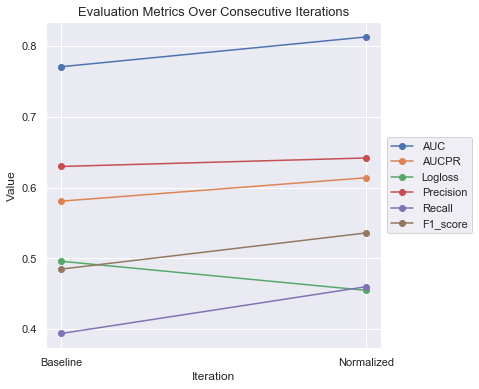

In [5]:
# Print evaluation metrics for baseline model
print('Baseline model:')
for m,v in clf_baseline_dict.items():
    print('{}: {:.3f}'.format(m, v))

# Print evaluation metrics for equalized model
print('\nNormalized model:')
for m,v in clf_norm_dict.items():
    print('{}: {:.3f}'.format(m, v))

# Plot the changes between both iterations
plot_consec_metric_delta('Baseline', clf_baseline_dict, 'Normalized', clf_norm_dict)

* Every evaluation metric improved after normalizing the numerical data and encoding the categorical data to binary integers.
* Let's revisit correlation between input variables to identify features we can possibly remove to reduce dimensionality and hopefully improve performance.

## 7. Feature Correlation

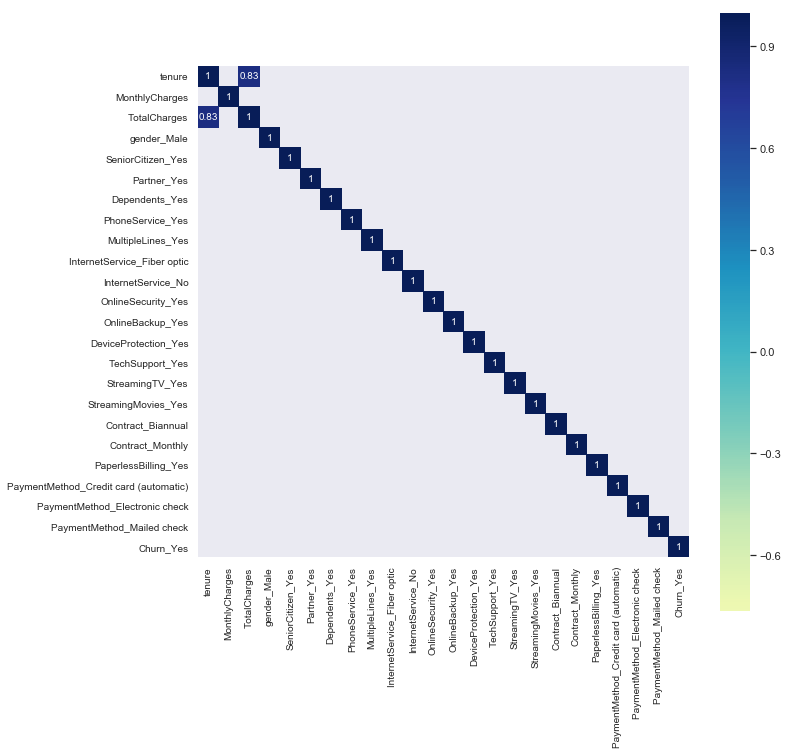

In [6]:
# Instantiate a mask for the weak correlations
weak_corr = ((0.80 > df_cat_encoded.corr()) & (df_cat_encoded.corr() > -0.80))

# Instantiate figure to render subsequent plot on
plt.figure(figsize=(11, 11))

# Draw heatmap
sns.heatmap(df_cat_encoded.corr(), 
            xticklabels=df_cat_encoded.corr().columns, 
            yticklabels=df_cat_encoded.corr().columns,
            center=0,
            cmap="YlGnBu",
            square=True,
            annot=True,
            mask=weak_corr);

# Set x and y tick (feature name) font sizes
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display plot
plt.show()

* TotalCharges and tenure are over 80% correlated with each other.
* Including this feature pair in some machine learning algorithms can create significant problems, while in others it will only introduce some minor redundancy and bias.
* Let's **remove TotalCharges** from the input features since it's a dependent variable - that's the product of tenure and MonthlyCharges.
* Removing this feature will reduce dimensionality and optimize the SVM's speed and predictive power.

### 7.1 Removing TotalCharges

In [7]:
# Define parameters
params = {
    'gamma': 'scale',
    'probability': True
}

# Create preprocessing pipeline for numeric and categorical data.
numeric_features = df.select_dtypes(exclude='object').columns.drop(['TotalCharges']).tolist()
numeric_transformer = Pipeline(steps=[
    ('normalize', Normalizer())
    
])

categorical_features = df.select_dtypes(include='object').columns.drop(['Churn', 'gender']).tolist()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_feat0 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(**params))
])

# Define target and features
X = df.drop(['Churn', 'gender', 'TotalCharges'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit model
clf_feat0.fit(X_train, y_train)

# Output results
clf_feat0_dict = OrderedDict()
metrics(clf_feat0, clf_feat0_dict)

AUC:       0.818
AUCPR:     0.602
Logloss:   0.453
Precision: 0.644
Recall:    0.494
F1-score:  0.559


* Let's analyze the how the removal of the TotalCharges feature impacted our evaluation metrics.

Normalized model:
AUC: 0.813
AUCPR: 0.614
Logloss: 0.455
Precision: 0.642
Recall: 0.460
F1_score: 0.536

Removed TotalCharges:
AUC: 0.818
AUCPR: 0.602
Logloss: 0.453
Precision: 0.644
Recall: 0.494
F1_score: 0.559


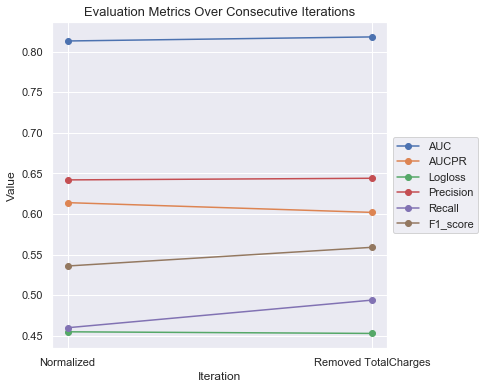

In [8]:
# Print evaluation metrics for baseline model
print('Normalized model:')
for m,v in clf_norm_dict.items():
    print('{}: {:.3f}'.format(m, v))

# Print evaluation metrics for equalized model
print('\nRemoved TotalCharges:')
for m,v in clf_feat0_dict.items():
    print('{}: {:.3f}'.format(m, v))

# Plot the changes between both iterations
plot_consec_metric_delta('Normalized', clf_norm_dict, 'Removed TotalCharges', clf_feat0_dict)

* The classifier's recall increased the most after removing TotalCharges.
* This is great! We want to optimize the recall for our business problem.
* Let's tune the algorithm's penalty parameter, C,  in the subsequent section.

## 8. Parameter C 
C is the penalty parameter of the error term. 
* We are using the training and testing data defined in section [7.1](#7.1-Removing-TotalCharges), where we dropped the TotalCharges from the input features.

In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time 

# Define parameters
params = {
    'gamma': 'scale', 
    'probability': True,
    'kernel': 'rbf'         # choose from: linear, poly, rbf, sigmoid, precomputed
}

# Set pipeline
clf_tune0 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(**params))
])

# Parameters to tune 
params_grid = {
    'clf__C':      np.arange(1, 15, 2)
}

# Perform GridSearchCV to find optimal parameters
clf_tune0_grid = GridSearchCV(
    estimator=clf_tune0,
    param_grid=params_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the grid search object
%time clf_tune0_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_tune0_grid.best_score_))
print('Best params:')
for key, val in clf_tune0_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.8min finished


CPU times: user 1min 54s, sys: 428 ms, total: 1min 54s
Wall time: 1min 54s
Best AUC score: 0.831
Best params:
	clf__C: 1


* The optimal **C** parameter is the same as the default value. 
* Here's our final SVC model.

## 9. Final Model

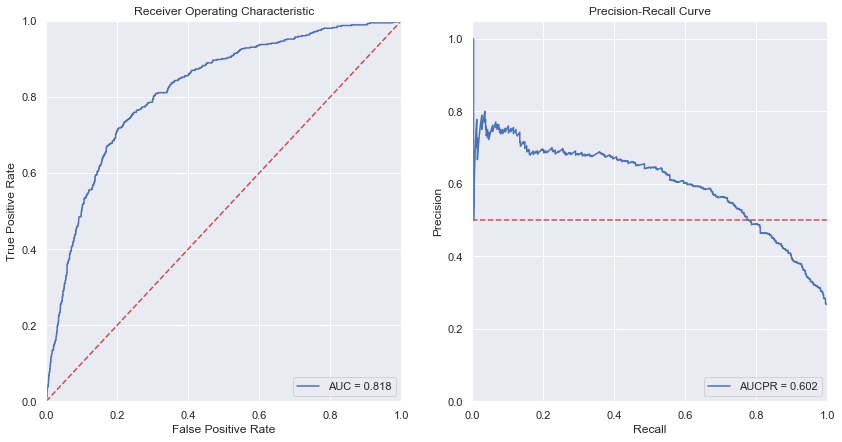

AUC:       0.818
AUCPR:     0.602
Logloss:   0.453
Precision: 0.644
Recall:    0.494
F1-score:  0.559


In [10]:
# Define parameters
params = {
    'gamma': 'scale', 
    'probability': True,
    'kernel': 'rbf',
    'C': 1
}

# Create preprocessing pipeline for numeric and categorical data.
numeric_features = df.select_dtypes(exclude='object').columns.drop(['TotalCharges']).tolist()
numeric_transformer = Pipeline(steps=[
    ('normalize', Normalizer())
    
])

categorical_features = df.select_dtypes(include='object').columns.drop(['Churn', 'gender']).tolist()
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(**params))
])

# Define target and features
X = df.drop(['Churn', 'gender', 'TotalCharges'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Fit model
clf_final.fit(X_train, y_train)

# Output results
clf_final_dict = OrderedDict()
plot_roc_pr(clf_final)
metrics(clf_final, clf_final_dict)